# PROJECT
4-connected grid (Manhattan distance)
input: map
output: self.path coordinates
References:
- Exercice 5

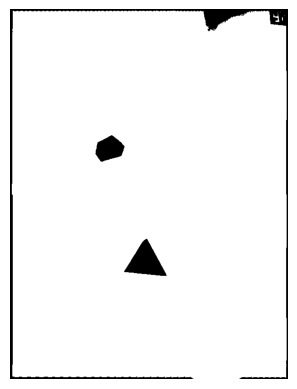

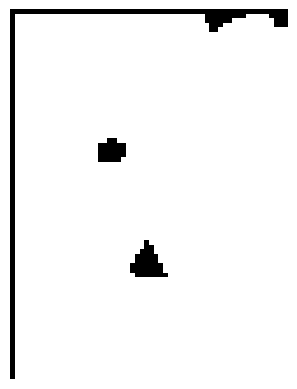

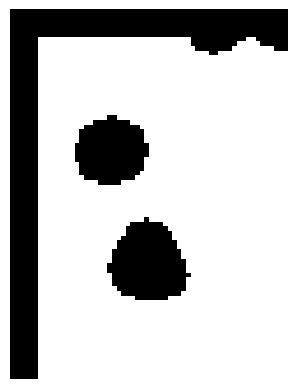

1248 operations to find the optimal path


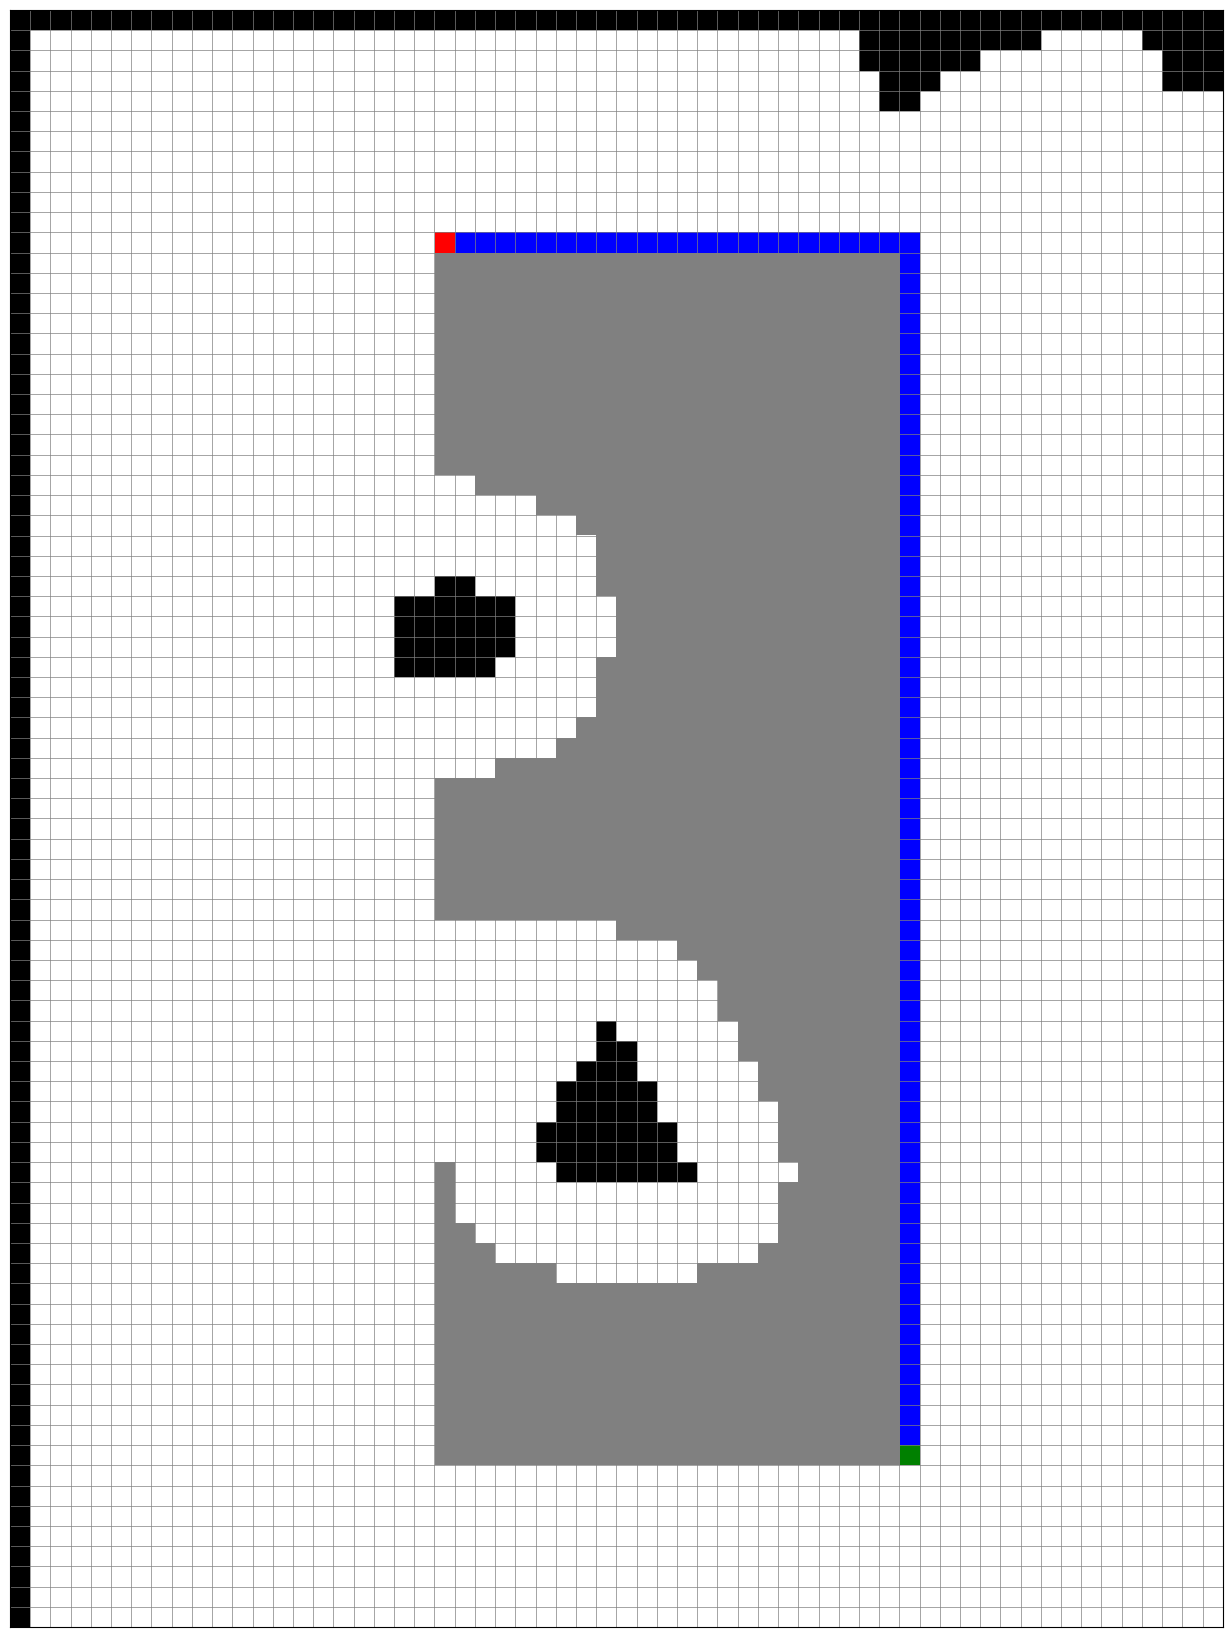

325 operations to find the optimal path


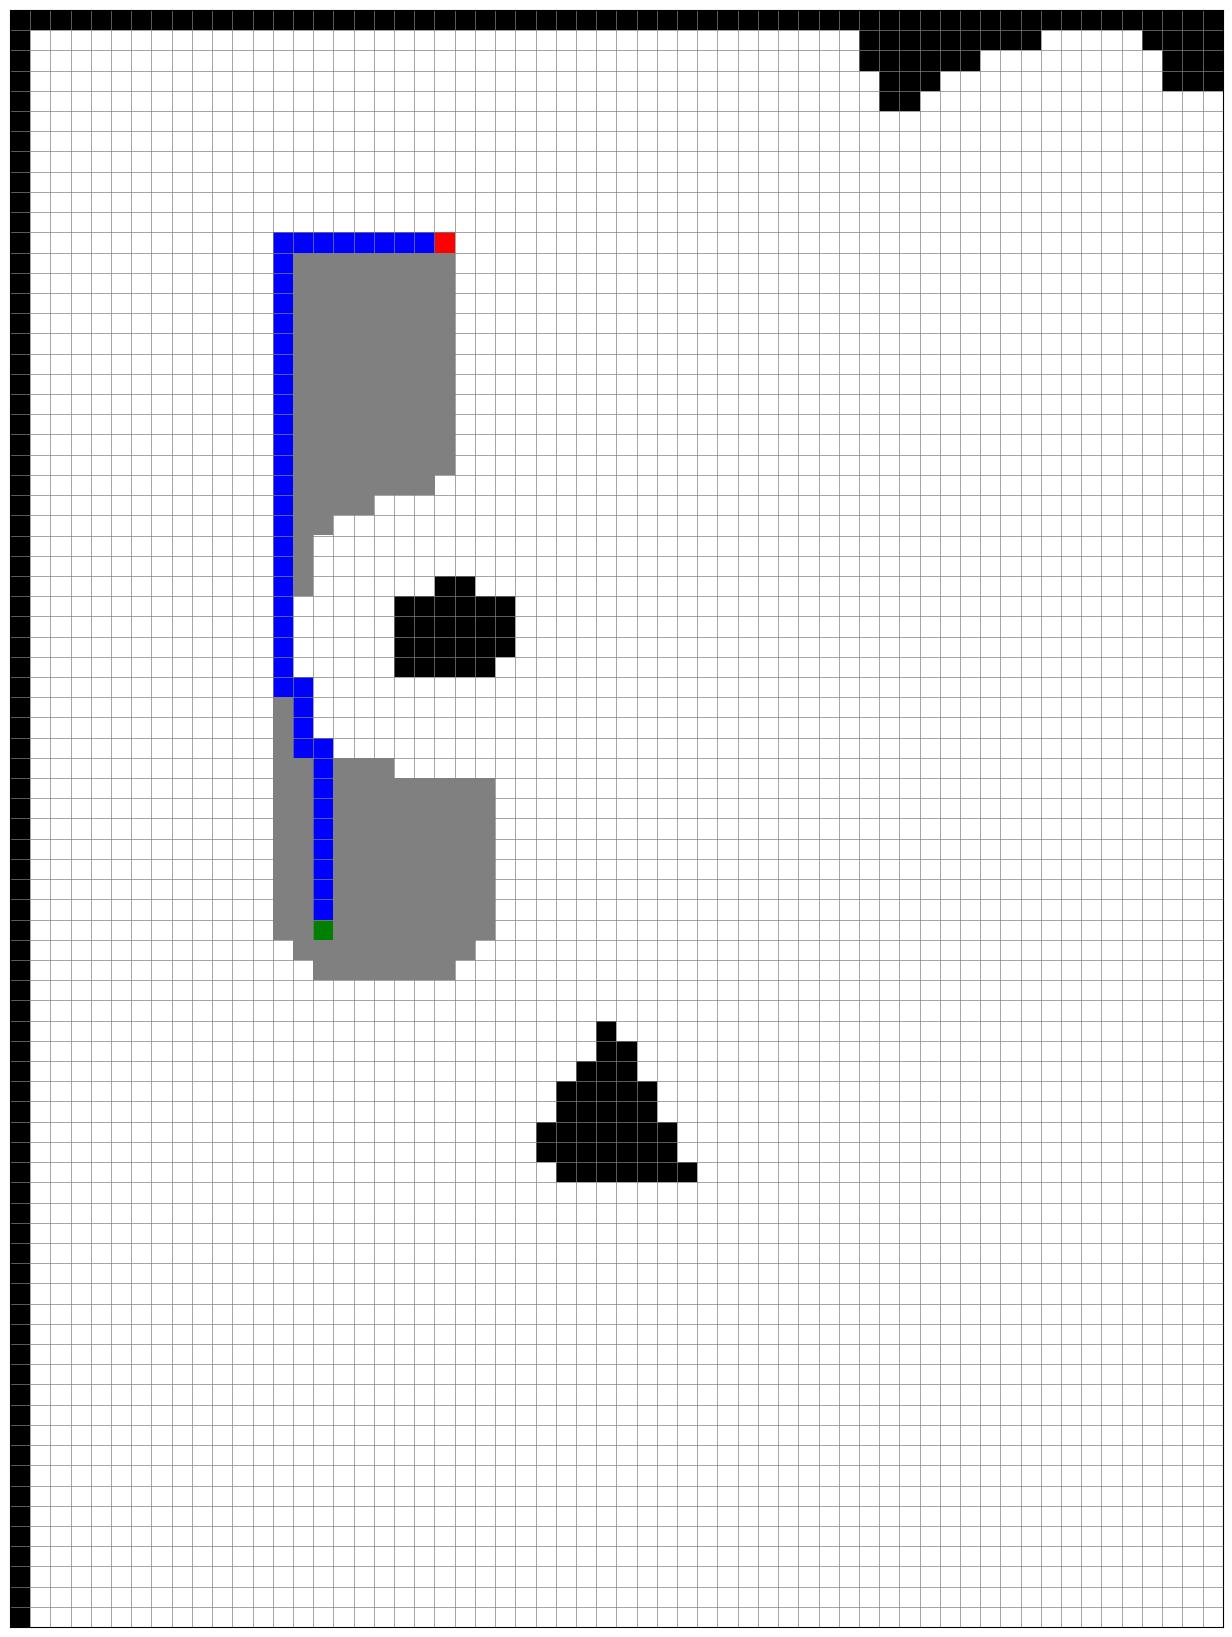

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop 
import cv2

class AStarNavigation:
    def __init__(self, file_path, safety):
        self.file_path = file_path
        self.safety = safety
        self.image = None
        self.start = None
        self.goal = None
        self.map_grid = None
        self.path = None

    def visualization_map(self):
        # Load the text file and convert it to a self.image
        self.image = np.loadtxt(self.file_path)

        # Find the coordinates of the first occurrence of the digit 2, 3
        self.start = tuple(np.argwhere(self.image == 2)[0])
        self.goal = tuple(np.argwhere(self.image == 3)[0])

        # Replace all occurrences of the digit 2 and 3 with 0 for the map
        self.image[self.start] = 0
        self.image[self.goal] = 0

        # conversion for display
        self.image = np.where(self.image == 0, 255, self.image)
        self.image = np.where(self.image == 1, 0, self.image)

        plt.imshow(self.image, cmap='gray')
        plt.axis('off')
        plt.show()
        
        # Resize the map to 100 pixels wide while maintaining the aspect ratio
        height, width = self.image.shape
        new_width = 60 #todo choose
        new_height = int((new_width / width) * height)
        self.image = cv2.resize(self.image, (new_width, new_height), interpolation=cv2.INTER_NEAREST) #todo explain
        
        # Update the start and goal positions after resizing
        start_y, start_x = self.start
        goal_y, goal_x = self.goal
        self.start = (int(start_y * new_height / height), int(start_x * new_width / width))
        self.goal = (int(goal_y * new_height / height), int(goal_x * new_width / width))
        
        
        # Display the self.image
        plt.imshow(self.image, cmap='gray')
        plt.axis('off')
        plt.show()
    
        # conversion for self.path planning
        self.image = np.where(self.image == 0, -1., self.image)
        self.image = np.where(self.image == 255, 0., self.image)

    def safety_distance(self):
        # Find the coordinates of all black pixels (value -1)
        black_pixels = np.argwhere(self.image == -1)
        self.image_thick = np.full_like(self.image, 255)
        
        # Iterate through each black pixel and draw a gray border around it
        for pixel in black_pixels:
            y, x = pixel
            cv2.circle(self.image_thick, (x, y), self.safety, 0, -1)
        
        plt.imshow(self.image_thick, cmap='gray')
        plt.axis('off')
        plt.show()
    
        # conversion for path planning
        self.image_thick = np.where(self.image_thick == 0, -1., self.image_thick)
        self.image_thick = np.where(self.image_thick == 255, 0., self.image_thick)
        return self.image_thick

    @staticmethod
    def heuristic(a, b):
        # Implement the Manhattan distance heuristic
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def algo(self):
        # Initialize the open set as a priority queue and add the self.start node
        open_set = []
        heappush(open_set, (self.heuristic(self.start, self.goal), 0, self.start))  # (f_cost, g_cost, position)
    
        # Initialize the came_from dictionary
        came_from = {}
        # Initialize g_costs dictionary with default value of infinity and set g_costs[self.start] = 0
        g_costs = {self.start: 0}
        # Initialize the explored set
        explored = set()
        operation_count = 0
        self.path = []
    
        while open_set:
            # Pop the node with the lowest f_cost from the open set
            current_f_cost, current_g_cost, current_pos = heappop(open_set)
    
            # Add the current node to the explored set
            explored.add(current_pos)
    
            # For directly reconstruct self.path
            if current_pos == self.goal:
                break
    
            # Get the neighbors of the current node (up, down, left, right)
            neighbors = [
                (current_pos[0] - 1, current_pos[1]),  # Up
                (current_pos[0] + 1, current_pos[1]),  # Down
                (current_pos[0], current_pos[1] - 1),  # Left
                (current_pos[0], current_pos[1] + 1)#,   # Right
                #(current_pos[0] - 1, current_pos[1] - 1),  # Up-Left
                #(current_pos[0] - 1, current_pos[1] + 1),  # Up-Right
                #(current_pos[0] + 1, current_pos[1] - 1),  # Down-Left
                #(current_pos[0] + 1, current_pos[1] + 1)   # Down-Right
            ]
    
            for neighbor in neighbors:
                # Check if neighbor is within bounds and not an obstacle
                if (0 <= neighbor[0] < self.map_grid.shape[0]) and (0 <= neighbor[1] < self.map_grid.shape[1]):
                    if self.map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                        # Determine cost for moving (diagonal or cardinal)
                        #step_cost = np.sqrt(2) if abs(neighbor[0] - current_pos[0]) == 1 and abs(neighbor[1] - current_pos[1]) == 1 else 1 #todo here
                        # Calculate tentative_g_cost
                        #tentative_g_cost = current_g_cost + step_cost + self.map_grid[neighbor[0], neighbor[1]] #todo here
    
                        
                        # Calculate tentative_g_cost
                        tentative_g_cost = current_g_cost + 1 + self.map_grid[neighbor[0], neighbor[1]]
    
                        # If this self.path to neighbor is better than any previous one
                        if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                            # Update came_from, g_costs, and f_cost
                            came_from[neighbor] = current_pos
                            g_costs[neighbor] = tentative_g_cost
                            f_cost = tentative_g_cost + self.heuristic(neighbor, self.goal)
    
                            # Add neighbor to open set
                            heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                            operation_count += 1
    
        # Reconstruct self.path
        if current_pos == self.goal:
            path = []
            while current_pos in came_from:
                self.path.append(current_pos)
                current_pos = came_from[current_pos]
            self.path.append(self.start)
            return self.path[::-1], explored, operation_count
        else:
            # If we reach here, no path was found
            return None, explored, operation_count

    def display_map(self, explored):
        cmap = ListedColormap(['white', 'black', 'blue', 'green', 'red', 'grey'])
        map_display = np.zeros_like(self.image, dtype=object)
    
        # Assign colors based on the map grid values
        map_display[self.image == -1] = 'black'  # Obstacles
        map_display[self.image == 0] = 'white'   # Free space
    
        for position in explored:
            if map_display[tuple(position)] == 'white':
                map_display[tuple(position)] = 'grey'  # Explored cells
    
        # Visualize the self.path
        for position in self.path:
            if map_display[position[0], position[1]] in ['white', 'grey']:
                map_display[position[0], position[1]] = 'blue'  # self.path
    
        #map_display[5, 3] = 'yellow' # Weighted cell
        map_display[self.start[0], self.start[1]] = 'green'  # self.start
        map_display[self.goal[0], self.goal[1]] = 'red'      # self.goal
    
        # Convert color names to numbers for plotting
        color_mapping = {'white': 0, 'black': 1, 'blue': 2, 'green': 3, 'red': 4, 'grey': 5}
        map_numeric_display = np.vectorize(color_mapping.get)(map_display)
        fig, ax = plt.subplots(figsize=(18, 21))
        ax.imshow(map_numeric_display, cmap=cmap)
        ax.set_xticks(np.arange(-0.5, self.image.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.image.shape[0], 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        #ax.set_title('a_star_search Visualization')
        plt.show()

    def solution(self, path, explored, operation_count):
        print(f"{operation_count} operations to find the optimal path")
        # Display the result
        if path:
            #print("self.path found:")
            #print(f"Number of operations: {operation_count}")
            self.display_map(explored)
            return path 
        else:
            print("No path found.")
            return None
            
    def run(self):
        self.visualization_map()
        self.map_grid = self.safety_distance()
        path, explored, operation_count = self.algo()
        return self.solution(path, explored, operation_count)

    def new_path(self, new_y, new_x):
        operation_count = 0
        self.start = (new_y, new_x)
        path, explored, operation_count = self.algo()
        return self.solution(path, explored, operation_count)
        
# Usage
file = "images/grid_map_6_8.txt"
safety = 5
navigator = AStarNavigation(file, safety)
path = navigator.run()
path = navigator.new_path(45, 15)